In [127]:
from sympy import *
from sympy.algebras.quaternion import Quaternion
import numpy as np
from scipy import linalg
from control import lqr
import pandas as pd
import os

class Controls:
    def __init__(
            self,
            t_motor_burnout: float = 1.971,
            t_estimated_apogee: float = 13.571,
            t_launch_rail_clearance: float = 0.164
        ):
        """Initialize the Controls class. Rocket body axis is aligned with y-axis.

        Args:
            t_motor_burnout (float, optional): Time until motor burnout in seconds. Defaults to 1.971.
        """
        self.t_motor_burnout = t_motor_burnout # seconds
        self.t_estimated_apogee = t_estimated_apogee # seconds
        self.t_launch_rail_clearance = t_launch_rail_clearance # seconds
        # self.csv_path = os.path.join(os.path.dirname(__file__), "important_data.csv")
        self.csv_path = "/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Club Stuff/LRI/FV-Controls/Control/important_data.csv"

    def getLineOfBestFitTime(self, var: str, n: int = 1):
        """Get the line of best fit for the given data with a polynomial of degree n.

        Args:
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 1.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        data = pd.read_csv(self.csv_path)
        t = data["# Time (s)"]
        y = None
        if (var == "mass"):
            y = data["Mass (g)"] / 1000  # Convert to kg
        elif (var == "inertia"):
            y = data["Longitudinal moment of inertia (kg·m²)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'mass'," \
                "'inertia'. " \
                )

        # Filter data based on motor burnout
        mask = t <= self.t_motor_burnout
        t = t[mask]
        y = y[mask]
        coeffs = np.polyfit(t, y, n)
        return coeffs, n


    def getLineOfBestFitAoA(self, burnout: str, var: str, n: int = 5):
        """Get the line of best fit for the given data with a polynomial of degree n. Choose from "stability margin" or "normal force coeff".

        Args:
            burnout (str): Choose from "pre burnout" or "post burnout".
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 5.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        data = pd.read_csv(self.csv_path)
        x = data["Angle of attack (°)"]
        if (var == "stability margin"):
            y = data["Stability margin calibers (​)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'stability margin'. "
                )

        launch_to_burnout = (data["# Time (s)"] >= self.t_launch_rail_clearance) & (data["# Time (s)"] < self.t_motor_burnout)
        burnout_to_apogee = (data["# Time (s)"] >= self.t_motor_burnout) & (data["# Time (s)"] <= self.t_estimated_apogee)
        if (burnout == "pre burnout"):
            x = x[launch_to_burnout]
            y = y[launch_to_burnout]
        elif (burnout == "post burnout"):
            x = x[burnout_to_apogee]
            y = y[burnout_to_apogee]
        else:
            raise ValueError(
                "Invalid motor_burnout. Choose from: " \
                "'pre burnout', " \
                "'post burnout'. "
                )

        coeffs = np.polyfit(x, y, n)
        return coeffs, n

    def getLineOfBestFitVel(self, var: str, n: int = 2):
        """Get the line of best fit for the given data with a polynomial of degree n.

        Args:
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 2.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        # TODO: set data to __init__ for efficiency
        data = pd.read_csv(self.csv_path)
        x = data["Total velocity (m/s)"]
        if (var == "drag force"):
            y = data["Drag force (N)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'drag force'. "
                )
        launch_to_apogee = (data["# Time (s)"] >= self.t_launch_rail_clearance) & (data["# Time (s)"] <= self.t_estimated_apogee)
        x = x[launch_to_apogee]
        y = y[launch_to_apogee]

        coeffs = np.polyfit(x, y, n)
        return coeffs, n

    def getTimeConstants(self, t: float):
        """Get the constants for the rocket at time t.

        Args:
            t (float): The time in seconds.

        Returns:
            dict: A dictionary containing the fin moments, corrective constants, mass, inertia, drag coeff, and drag force.
        """

        constants = dict()
        I = Matrix([0.004, 0.004, 0.29]) # Post burnout inertia values from OpenRocket, kg*m^2
        m = 2.589  # Post burnout mass from OpenRocket, kg
        T = Matrix([0., 0., 0.])  # N

        motor_burnout = t > self.t_motor_burnout

        # TODO: for added efficiency, only call getLineOfBestFitTime once per variable and store the results
        if not motor_burnout:
            coeffs_mass, degree_mass = self.getLineOfBestFitTime("mass")
            m = sum(coeffs_mass[i] * t**(degree_mass - i) for i in range(degree_mass + 1))

            coeffs_inertia, degree_inertia = self.getLineOfBestFitTime("inertia")
            I[2] = sum(coeffs_inertia[i] * t**(degree_inertia - i) for i in range(degree_inertia + 1))

            times = pd.read_csv(self.csv_path)["# Time (s)"]
            thrust = pd.read_csv(self.csv_path)["Thrust (N)"]
            T[2] = np.interp(t, times, thrust) # Thrust acting in z direction

        constants["inertia"] = I
        constants["mass"] = m
        constants["thrust"] = T
        
        return constants
    def getAileronMoment(self, delta1: Symbol, v3: float):
        """Get the aileron moment based on the aileron angle.

        Args:
            delta1 (float): The aileron angle in radians.
            v3 (float): The vertical velocity in m/s.
        Returns:
            Matrix: The symbolic moment vector [Mx, My, Mz] function of the aileron angle and rocket's vertical velocity.
        """
        
        M1, M2 = 0, 0
        # Verify later with data points
        M3 = delta1/8 * (4.11522634e-09*(v3**3) 
                        - 1.04938272e-06*(v3**2) 
                        + 3.35185185e-04*v3 
                        - 1.22222222e-02) # v3 = vertical velocity, Mz = roll moment

        return Matrix([M1, M2, M3])
    

    def getAB(self, t: float, v3: float):
        M3, I3 = symbols('M_3 I_3', real = True) # Moment and inertia about z-axis
        w3, delta1 = symbols('w_3 delta_1', real = True) # Angular velocity about z-axis, aileron angle
        Dr = 0 # Rotational damping coefficient, TODO: find actual value
        w3dot = (M3 - Dr * w3) / I3
        f = Matrix([
            [w3dot]
        ])

        m = Matrix([w3]) # State vector
        n = Matrix([delta1]) # Input vector

        constants = self.getTimeConstants(t)
        mass_rocket = constants["mass"]
        inertia = constants["inertia"]
        thrust = constants["thrust"]

        Mf = Matrix([0.003, 0.003, 0.003])  # Fin misalignment from open rocket
        M = Mf + self.getAileronMoment(delta1, v3)

        params = {
            I3: Float(inertia[2]),
            M3: M[2]
        }

        f = f.subs(params)

        m_e = {
            w3: 0
        }
        delta1_e = solve(f.subs(m_e), delta1, dict=True)[0][delta1]
        # print(delta1_e)
        n_e = {
            delta1: delta1_e
        }

        A = f.jacobian(m).subs(m_e).subs(n_e)
        B = f.jacobian(n).subs(m_e).subs(n_e)

        f_subs = f.subs(m_e).subs(n_e)

        return A, B, f_subs, f


In [84]:
t = pd.read_csv("/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Club Stuff/LRI/FV-Controls/Control/important_data.csv")["# Time (s)"]
v = pd.read_csv("/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Club Stuff/LRI/FV-Controls/Control/important_data.csv")["Total velocity (m/s)"]
w = pd.read_csv("/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Club Stuff/LRI/FV-Controls/Control/important_data.csv")["Roll rate (°/s)"]
w = w * np.pi / 180 # convert to rad/s

As = []
Bs = []
Ks = []

for i in range(347):
    A, B, _, _ = Controls().getAB(t[i], v[i])
    A = np.array(A).astype(float)
    B = np.array(B).astype(float)
    Q = np.diag([1]) # State cost matrix
    R = np.diag([1]) # Input cost matrix
    K, _, _ = lqr(A, B, Q, R)

    As.append(A)
    Bs.append(B)
    Ks.append(K)

    # print(f"t = {t[i]:.3f}, v = {v[i]:.3f}, A = {A}, B = {B}, K = {K}")

Ks[1]

array([[-0.93461926]])

In [93]:
print("A = ", As[1])
print("B = ", Bs[1])
print("K = ", Ks[1])

A =  [[-0.00030685]]
B =  [[-0.00453464]]
K =  [[-0.93461926]]


In [154]:
mask = t <= 13.571
t = t[mask]
v = v[mask]

dt = np.diff(t)                        # time steps, length N-1
N  = len(t)
x  = np.zeros(N)                       # state history
u  = np.zeros(N-1)                     # input history
x[0] = 1e-3
Q = np.diag([1]) # State cost matrix
R = np.diag([1e-5]) # Input cost matrix

for k in range(N-1):
    A, B, _, _ = Controls().getAB(t[k], v[k])
    A = np.array(A).astype(float)
    B = np.array(B).astype(float)
    K, _, _ = lqr(A, B, Q, R)

    u[k] = -K[0][0] * x[k]                   # state feedback
    # Clamp control input to physical limits
    u_lim = np.deg2rad(8)
    u[k] = np.clip(u[k], -u_lim, u_lim) # aileron angle limits
    xdot = A[0][0] * x[k] + B[0][0] * u[k]
    x[k+1] = x[k] + dt[k] * xdot       # Euler step
    if (k+1) == 75:
        x[k+1] = -1e-3

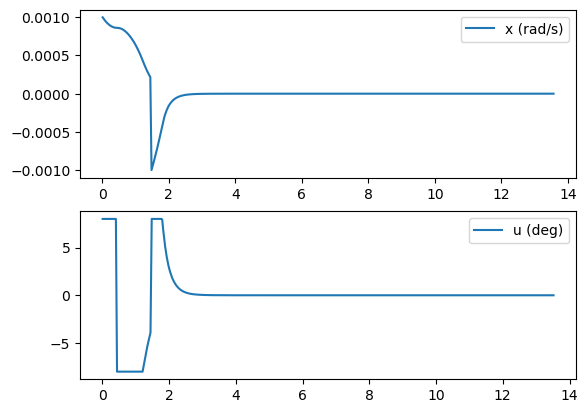

In [155]:
# Plotting
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, x, label='x (rad/s)')
# plt.plot(t, w, label='w (rad/s)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t[:-1], u * 180/np.pi, label='u (deg)')
plt.legend()

In [47]:
A

Matrix([[0]])

In [33]:
B

Matrix([[0.0059068693338613]])